In [1]:
!pip install wandb

In [2]:
import pickle
with open('/content/drive/MyDrive/Gopal/Gopal_Xs.pkl', 'rb') as f:
    Xs = pickle.load(f)
with open('/content/drive/MyDrive/Gopal/Gopal_X_stat_s.pkl', 'rb') as f:
    X_stat = pickle.load(f)
with open('/content/drive/MyDrive/Gopal/Gopal_ys.pkl', 'rb') as f:
    ys = pickle.load(f)

In [3]:
print(len(Xs))

3245


In [3]:



import wandb


epochs = 15

wandb.login(key='---')
wandb.init(project="NeuralFactors32", entity="jswc5233")  # Adjust names
wandb.config.update({"epochs": epochs, "learning_rate": 1e-4, "weight_decay": 1e-6})


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jswc5233. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Read data

In [5]:
## log scale or std scale; some feature is better log scales
## sometimes normalize (std, make sure zero)
## flag - use alpha or not False

In [4]:
import torch
import numpy as np

flattened_Xs = [torch.tensor(X).view(-1, 16) for X in Xs]  # Flatten to (*, 14) (9xx, 5, 14)
all_X = torch.cat(flattened_Xs, dim=0)  # Shape: (total_samples, 14)

# Compute the max and min along the last dimension (14 features)
X_mean = all_X[:, :13].mean(dim=0)  # Shape: (13,)
X_std = all_X[:, :13].std(dim=0)  # Shape: (13,)

# print("Global Min per feature:", X_min)
# print("Global Max per feature:", X_max)

In [5]:
import numpy as np

def build_indices_to_ragged(Xs):
    group_lengths = [len(X) for X in Xs]
    indices_to_ragged = np.repeat(np.arange(len(group_lengths)), group_lengths)
    return indices_to_ragged

def filter_and_subset(Xs_concat, X_stat_concat, ys_concat, indices_to_ragged, low_bounds, high_bounds):
    # Use only the first 13 features for filtering
    X_to_filter = Xs_concat[:, :13]

    # Create mask for rows within the bounds
    mask = np.all((X_to_filter >= low_bounds) & (X_to_filter <= high_bounds), axis=1)
    Xs_concat_filtered = Xs_concat[mask]
    X_stat_concat_filtered = X_stat_concat[mask]
    ys_concat_filtered = ys_concat[mask]
    indices_to_ragged_filtered = indices_to_ragged[mask]

    return Xs_concat_filtered, X_stat_concat_filtered, ys_concat_filtered, indices_to_ragged_filtered

def reorganize_to_ragged(Xs_concat_filtered, X_stat_concat_filtered, ys_concat_filtered, indices_to_ragged_filtered):
    # Get unique ragged indices and counts
    unique_indices, counts = np.unique(indices_to_ragged_filtered, return_counts=True)

    # Split the filtered arrays based on counts
    Xs_ragged = np.split(Xs_concat_filtered, np.cumsum(counts[:-1]))
    X_stat_ragged = np.split(X_stat_concat_filtered, np.cumsum(counts[:-1]))
    ys_ragged = np.split(ys_concat_filtered, np.cumsum(counts[:-1]))

    return Xs_ragged, X_stat_ragged, ys_ragged

In [6]:
Xs_concat = np.concatenate(Xs, axis=0)
epsilon = 1e-6
features_to_log_scale = [0, 1, 2, 3, 4, 5, 6]
for fea in features_to_log_scale:
  print(Xs_concat[:,:,fea].max())
  print(Xs_concat[:,:,fea].min())
  feature_min = Xs_concat[:, :, fea].min()

  if feature_min < 0:
      shift = abs(feature_min) + 0.1
  elif feature_min == 0:
      shift = 0.1
  else:
      shift = 0
  Xs_concat[:, :, fea] = np.log(Xs_concat[:, :, fea] + shift)


X_stat_concat = np.concatenate(X_stat, axis=0)
ys_concat = np.concatenate(ys, axis=0)

# Build indices_to_ragged
indices_to_ragged = build_indices_to_ragged(Xs)

# Define global bounds for filtering
#X_flat = Xs_concat[:, :, :13].reshape(-1, 13)  # Shape: (3992309 * 5, 13)
low_bounds = np.percentile( Xs_concat[:, :, :13], 1, axis=(0,1))  # Shape: (13,)
high_bounds = np.percentile( Xs_concat[:, :, :13], 99, axis=(0,1))  # Shape: (13,)

mask_per_timestep = (Xs_concat[:, :, :13] >= low_bounds) & (Xs_concat[:, :, :13] <= high_bounds)  # Shape: (3992309, 5, 13)
mask_per_series = np.all(mask_per_timestep, axis=(1, 2)) # Shape: (3992309,)

Xs_concat_filtered = Xs_concat[mask_per_series]  # Shape: (filtered_samples, 5, 16)
X_stat_concat_filtered = X_stat_concat[mask_per_series]  # Shape: (filtered_samples, 4)
ys_concat_filtered = ys_concat[mask_per_series]
indices_to_ragged_filtered = indices_to_ragged[mask_per_series]

56625.6
-9243.9
99.669
0.08
3.549
0.01
2000116.0
0.0
22.698
0.0
165168.0
0.0
126.467
0.0


In [10]:
X_max = Xs_concat_filtered[:,:,:13].max(axis=(0,1))  # Shape: (13,)
X_min = Xs_concat_filtered[:,:,:13].min(axis=(0,1))  # Shape: (13,)

X_max = torch.tensor(X_max)
X_min = torch.tensor(X_min)

Xs_ragged, X_stat_ragged, ys_ragged = reorganize_to_ragged(
    Xs_concat_filtered, X_stat_concat_filtered, ys_concat_filtered, indices_to_ragged_filtered
)

In [11]:
X_max.shape

torch.Size([13])

In [12]:
# pre-process and normalize

Xs_ = []
X_stat_s_ = []
ys_ = []

for X, x_stat, y in zip(Xs, X_stat, ys):
    X_tensor = torch.tensor(X)  # Shape: (N_t, 5, 16)
    x_stat_tensor = torch.tensor(x_stat) / torch.tensor([1, 1, 10, 100])
    y_tensor = torch.tensor(y)

    X_to_normalize = X_tensor[..., :13]  # Shape: (N_t, 5, 13)
    X_to_spare = X_tensor[..., 13:]      # Shape: (N_t, 5, remaining)

    X_to_normalize_normalized = (X_to_normalize - X_min.unsqueeze(0).unsqueeze(0)) / \
                                (X_max.unsqueeze(0).unsqueeze(0) -X_min.unsqueeze(0).unsqueeze(0))

    X_combined = torch.cat((X_to_normalize_normalized, X_to_spare), dim=-1)

    Xs_.append(X_combined)
    X_stat_s_.append(x_stat_tensor)
    ys_.append(y_tensor)


# Modeling

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim, d_factor):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc_alpha = nn.Linear(hidden_dim + static_dim, 1)
        self.fc_beta = nn.Linear(hidden_dim + static_dim, d_factor)
        self.fc_sigma = nn.Linear(hidden_dim + static_dim, 1)
        #self.fc_nu = nn.Linear(hidden_dim + static_dim, 1)

    def forward(self, stock_time_series, stock_static):
        # hidden - (num_layers * num_directions, batch_size, hidden_dim)
        _, (hidden, _) = self.lstm(stock_time_series)  # hidden: (2, N_t, hidden_dim)
        hidden = hidden[-1]  # Shape: (N_t, hidden_dim)

        combined = torch.cat([hidden, stock_static], dim=1)  # Shape: (N_t, hidden_dim + static_dim)
        alphas = self.fc_alpha(combined).transpose(0,1) # Shape: (1,N_t)
        betas = self.fc_beta(combined)  # (d_factor, N_t)
        #sigmas = torch.exp(self.fc_sigma(combined)).transpose(0,1)  # Shape: (1,N_t), ensure positive
        sigmas = F.softplus(self.fc_sigma(combined)).transpose(0,1)
        #nus = F.softplus(self.fc_nu(combined)).transpose(0,1) + 4  # Shape: (1,N_t), ensure finite kurtosis

        return alphas, betas, sigmas#, nus


In [14]:
from torch.distributions import MultivariateNormal
from torch.linalg import cholesky

def T_log_prob(z, mu, sigmas, nu): # z is (20,N_t) while mu is (1,N_t)
    dim = z.shape[-1] # = N_t
    t = 0.5 * (nu + dim)

    # Deviations
    dev = z - mu  # (N, N_t)
    # Mahalanobis sum over N_t
    #maha = torch.sum((dev)**2 / sigma, dim=-1)  # Mahalanobis distance (N,) # SIGMA IS VAR
    maha = torch.sum((dev / sigmas)**2, dim=-1) # SIGMA IS SD

    # Compute individual terms
    A = torch.lgamma(t)  # sca
    B = torch.lgamma(0.5 * nu)  # sca
    C = dim / 2. * torch.log(torch.tensor(nu * np.pi, dtype=torch.float32))  # sca
    #D = 0.5 * torch.sum(torch.log(sigma), dim=1)  # (1,) # SIGMA IS VAR
    D = torch.sum(torch.log(sigmas), dim=1)  # (1,) # SIGMA IS SD
    E = -t * torch.log(1 + maha / nu)  # (N,)

    return A - B - C - D + E

def T_log_prob_x_giv_z(r_future, pred_mean, sigmas, nu): #r_futue is (1,N_t) while pred_means is (20,N_t)
    dim = r_future.shape[-1] # = N_t
    t = 0.5 * (nu + dim)

    # Deviations
    dev = r_future - pred_mean  # (N, N_t)
    # Mahalanobis sum over N_t
    #maha = torch.sum((dev)**2 / sigma, dim=-1)  # Mahalanobis distance (N,) # SIGMA IS VAR
    maha = torch.sum((dev / sigmas)**2, dim=-1) # SIGMA IS SD

    # Compute individual terms
    A = torch.lgamma(t)  # sca
    B = torch.lgamma(0.5 * nu)  # sca
    C = dim / 2. * torch.log(torch.tensor(nu * np.pi, dtype=torch.float32))  # sca
    #D = 0.5 * torch.sum(torch.log(sigma), dim=1)  # (1,) # SIGMA IS VAR
    D = torch.sum(torch.log(sigmas), dim=1)  # (1,) # SIGMA IS SD
    E = -t * torch.log(1 + maha / nu)  # (N,)

    return A - B - C - D + E, E.detach().sum().item(), D.detach().sum().item()

class FactorModelVAE(nn.Module):
    def __init__(self, d_ts, d_static, hidden_size=256, d_factor=4, num_samples=20):
        super(FactorModelVAE, self).__init__()
        self.lstm_model = LSTMModel(d_ts, d_static, hidden_size, d_factor)
        self.d_factor = d_factor
        self.num_samples = num_samples
        self.mu_z_prior = torch.zeros((1,d_factor))  # (1,d_factor)
        self.Sigma_z_prior = torch.ones((1,d_factor))  # (1,d_factor)
        self.nu_prior = nn.Parameter(torch.Tensor([5.0])) # (1,)
        self.nu_prior.requires_grad = True
        self.nu_posterior = nn.Parameter(torch.Tensor([5.0])) # (1,)
        self.nu_posterior.requires_grad = True
        self.szpi = None

    def qzx_parameters(self, alphas, betas, sigmas, nus, r_future):
        Sigma_z_post_inv = torch.diag(1/self.Sigma_z_prior.squeeze(0)) + betas.T @ torch.diag(1/sigmas.squeeze(0)**2) @ betas
        self.szpi = Sigma_z_post_inv.detach().clone().numpy()
        L = cholesky(Sigma_z_post_inv)

        ## mu = self.mu_z_prior/self.Sigma_z_prior +  ((r_future-alphas)/sigmas) @ betas # SIGMAS ARE VAR
        mu = self.mu_z_prior +  ((r_future-alphas)/sigmas**2) @ betas # SIGMAS ARE SD

        mu = mu.view(-1,1)
        mu = torch.cholesky_solve(mu, L)
        return L, mu.squeeze(-1) # (d_factor,) since rsample will copy this shape

    def forward(self, time_series_data, static_features, r_future, Sigma_z):
        """
        r_future - (1,N_t)
        """
        N_t = r_future.shape[-1] # = N_t
        alphas, betas, sigmas = self.lstm_model(time_series_data, static_features) # (1,N_t), (N_t, d_factor), (1,N_t).     , (1,N_t)
        print('[[MONITOR]]', 'max_sigma', torch.max(sigmas).item(), 'Q3_sigma', torch.quantile(sigmas, 0.75).item(), 'min_sigma', torch.min(sigmas).item())
              # 'nu_post', self.nu_posterior.item(), 'z_nu', self.nu_prior)
        L, mu_z_post = self.qzx_parameters(alphas, betas, sigmas, self.nu_posterior, r_future)
        print('L det', torch.det(L).item())
        P = L@L.T

        U, S, V = torch.svd(betas)
        betas_nuc = np.sum(S.detach().numpy())
        betas_l2 = S[0].item()


        mvn = MultivariateNormal(mu_z_post, precision_matrix=P)
        z_samples = mvn.rsample((20,)) # (20, d_factor)
        log_qzx = mvn.log_prob(z_samples) # (20,)


        log_pz = T_log_prob(z_samples, self.mu_z_prior, self.Sigma_z_prior, self.nu_prior) # (20,)
        predicted_mean = alphas + z_samples @ betas.T # (1,N_t)<+>(20,N_t)=(20,N_t)
        log_pxz, maha_term, sigma_term = T_log_prob_x_giv_z(r_future, predicted_mean, sigmas, self.nu_posterior)

        print('[[ELBO]]:', maha_term, '+', sigma_term,' + ',log_pxz.mean().item(),' - ', log_qzx.mean().item())

        return ( -torch.logsumexp(log_pxz + log_pz - log_qzx, dim=0) + torch.log(torch.tensor(self.num_samples, dtype=torch.float32)) )/N_t , maha_term, sigma_term, log_pxz.mean().item(), log_qzx.mean().item(), torch.det(L).item(), betas_nuc, betas_l2, torch.max(sigmas).item(), torch.min(sigmas).item()


In [15]:
#Xs[0].shape

In [18]:
# Define the dimensions of your input data
d_ts = Xs[0].shape[2]  # Number of time-series features (e.g., financial ratios)
d_static = 4  # Number of static features (e.g., company information)
hidden_size = 256  # Hidden size for the LSTM
d_factor = 32  # Latent dimension size (number of latent factors) -
num_samples = 20

print('d_ts = ', d_ts)

def initialize_lstm_weights(lstm):
    for name, param in lstm.named_parameters():
        if 'weight' in name:
            nn.init.xavier_normal_(param)  # Xavier initialization for weights
        elif 'bias' in name:
            nn.init.constant_(param, 0)

# Instantiate the model
model = FactorModelVAE(d_ts=d_ts, d_static=d_static, hidden_size=hidden_size, d_factor=d_factor, num_samples=num_samples)
initialize_lstm_weights(model.lstm_model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

d_ts =  16


In [19]:
import time

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
durations = []


for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    Sigma_z = torch.ones((1,model.d_factor))
    for X, x_stat,y in zip(Xs, X_stat_s_, ys):
        X_ = torch.tensor(X, dtype=torch.float32)
        x_stat_ = torch.tensor(x_stat, dtype=torch.float32)
        y_ = torch.tensor(y, dtype=torch.float32)
        optimizer.zero_grad()

        loss, maha_term, sigma_term, log_pxz, log_qzx, Ldet, betas_nuc, betas_l2, maxsigma, minsigma = model(X_, x_stat_, y_, Sigma_z)

        # Backward pass and optimization
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.lstm_model.parameters(), max_norm=.5)
        optimizer.step()

        running_loss += loss.item()

        wandb.log({
            "loss": loss.item(),
            "maha_term": maha_term,
            "sigma_term": sigma_term,
            "log_pxz": log_pxz,
            "log_qzx": log_qzx,
            "Ldet": Ldet,
            "betas_nuc": betas_nuc,
            "betas_l2": betas_l2,
            "maxsigma": maxsigma,
            "minsigma": minsigma
        })

    avg_loss = running_loss / len(Xs)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch in seconds
    durations.append(epoch_duration)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Duration: {epoch_duration:.2f} seconds')

    wandb.log({"epoch_duration": epoch_duration})

print('Yay!')
print('Total Duration:', sum(durations), 'seconds')


# Save model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1,  # Save the current epoch for resuming
    'loss': avg_loss     # Optionally save the loss for resuming
}, '/content/drive/MyDrive/64model_epoch.pth')




<ipython-input-19-6a83133b7a51>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stat_ = torch.tensor(x_stat, dtype=torch.float32)
<ipython-input-14-d58156069de3>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = dim / 2. * torch.log(torch.tensor(nu * np.pi, dtype=torch.float32))  # sca
<ipython-input-14-d58156069de3>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = dim / 2. * torch.log(torch.tensor(nu * np.pi, dtype=torch.float32))  # sca


[[MONITOR]] max_sigma 0.6890000700950623 Q3_sigma 0.5072866082191467 min_sigma 0.1762128621339798
L det 2.3091135232630904e+23
[[ELBO]]: -23109.861328125 + -828.6118774414062  +  885.3076171875  -  8.218134880065918


<ipython-input-19-6a83133b7a51>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stat_ = torch.tensor(x_stat, dtype=torch.float32)
<ipython-input-14-d58156069de3>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = dim / 2. * torch.log(torch.tensor(nu * np.pi, dtype=torch.float32))  # sca
<ipython-input-14-d58156069de3>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = dim / 2. * torch.log(torch.tensor(nu * np.pi, dtype=torch.float32))  # sca


[[MONITOR]] max_sigma 0.6821837425231934 Q3_sigma 0.4921737313270569 min_sigma 0.16906368732452393
L det 6.168227327398583e+23
[[ELBO]]: -78327.234375 + -866.4388427734375  +  -1836.0201416015625  -  8.756494522094727
[[MONITOR]] max_sigma 0.6863629221916199 Q3_sigma 0.479383647441864 min_sigma 0.16457131505012512
L det 1.5688488901480608e+24
[[ELBO]]: -41955.1875 + -897.0718994140625  +  14.9295654296875  -  9.57255744934082
[[MONITOR]] max_sigma 0.6837100386619568 Q3_sigma 0.47693511843681335 min_sigma 0.1616281121969223
L det 2.289624285947637e+24
[[ELBO]]: -127876.90625 + -908.6813354492188  +  -4269.5556640625  -  9.28676700592041
[[MONITOR]] max_sigma 0.673220157623291 Q3_sigma 0.4736814796924591 min_sigma 0.15850436687469482
L det 3.108306352379179e+24
[[ELBO]]: -22737.42578125 + -914.0265502929688  +  992.7530517578125  -  9.899259567260742
[[MONITOR]] max_sigma 0.6615498661994934 Q3_sigma 0.46627557277679443 min_sigma 0.152989000082016
L det 4.909272352588984e+24
[[ELBO]]: -21

ValueError: Expected parameter precision_matrix (Tensor of shape (32, 32)) of distribution MultivariateNormal(loc: torch.Size([32]), precision_matrix: torch.Size([32, 32])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[ 5.8882e+07,  1.0695e+08, -1.1233e+08,  ..., -1.7342e+07,
          3.2979e+07, -5.1136e+07],
        [ 1.0695e+08,  1.9434e+08, -2.0411e+08,  ..., -3.1546e+07,
          5.9960e+07, -9.2961e+07],
        [-1.1233e+08, -2.0411e+08,  2.1438e+08,  ...,  3.3130e+07,
         -6.2974e+07,  9.7637e+07],
        ...,
        [-1.7342e+07, -3.1546e+07,  3.3130e+07,  ...,  5.1444e+06,
         -9.7578e+06,  1.5112e+07],
        [ 3.2979e+07,  5.9960e+07, -6.2974e+07,  ..., -9.7578e+06,
          1.8531e+07, -2.8708e+07],
        [-5.1136e+07, -9.2961e+07,  9.7637e+07,  ...,  1.5112e+07,
         -2.8708e+07,  4.4502e+07]], grad_fn=<ExpandBackward0>)

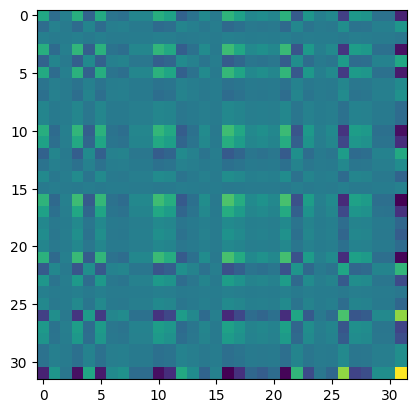

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(model.szpi)

In [ ]:
print(model.szpi.max())
print(model.szpi.min())

454642000.0
-327309760.0


# Visualize

In [ ]:
# Load checkpoint
import torch
checkpoint = torch.load('/content/drive/MyDrive/64model_epoch.pth')

# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

<ipython-input-8-499a821f08c0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/64model_epoch.pth')


FactorModelVAE(
  (lstm_model): LSTMModel(
    (lstm): LSTM(16, 256, num_layers=2, batch_first=True)
    (fc_alpha): Linear(in_features=260, out_features=1, bias=True)
    (fc_beta): Linear(in_features=260, out_features=4, bias=True)
    (fc_sigma): Linear(in_features=260, out_features=1, bias=True)
  )
)

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings):

    # Convert embeddings to NumPy for PCA
    embeddings_np = embeddings.cpu().detach().numpy()

    # Apply PCA to reduce dimensions to 2 for visualization
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings_np)

    # Plot the PCA-reduced embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', edgecolors='k', alpha=0.7)
    plt.title('PCA of LSTM Embeddings')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid(True)
    plt.show()


In [ ]:
alphas, betas, sigmas = model.lstm_model(stock_time_series=torch.tensor(Xs[0],dtype=torch.float32),
                                              stock_static=torch.tensor(X_stat_s_[0],dtype=torch.float32))


<ipython-input-11-379073d94ec2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stock_static=torch.tensor(X_stat_s_[0],dtype=torch.float32))


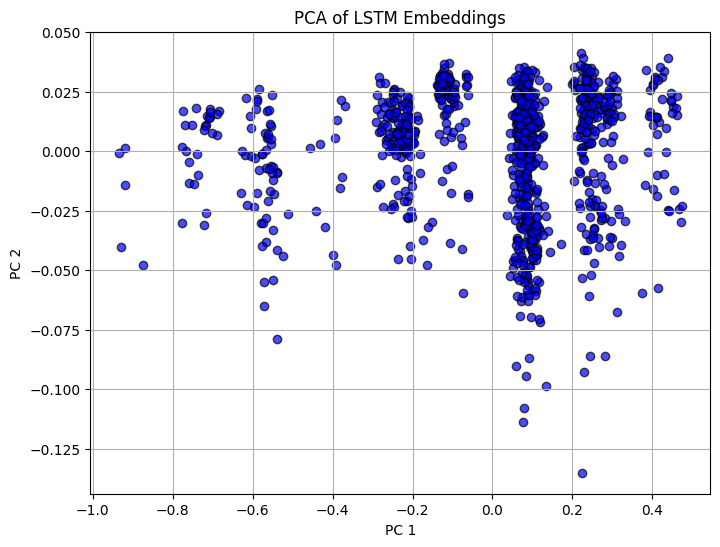

In [ ]:
visualize_embeddings(betas)

In [ ]:
def windsorize(data, lower_percentile=1, upper_percentile=99):
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array.")
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D NumPy array.")

    # Compute thresholds for each column
    lower_thresholds = np.percentile(data, lower_percentile, axis=0)
    upper_thresholds = np.percentile(data, upper_percentile, axis=0)

    # Windsorize: Clip values outside thresholds
    return np.clip(data, lower_thresholds, upper_thresholds)

In [ ]:
all_factors = []

with torch.no_grad():
    for X_t, X_stat_t, y_t in zip(Xs, X_stat_s_, ys):
        X_t = torch.tensor(X_t, dtype=torch.float32)
        X_stat_t = torch.tensor(X_stat_t, dtype=torch.float32)
        y_t = torch.tensor(y_t, dtype=torch.float32)

        alphas, betas, sigmas = model.lstm_model(X_t, X_stat_t)
        L, mu_z_post = model.qzx_parameters(alphas, betas, sigmas, model.nu_posterior, y_t)
        P = L @ L.T

        all_factors.append(mu_z_post)

all_factors = torch.stack(all_factors, dim=0)


<ipython-input-19-f202d162ec35>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_stat_t = torch.tensor(X_stat_t, dtype=torch.float32)


In [ ]:
all_factors.max(axis=0)

torch.return_types.max(
values=tensor([ 0.1536,  0.1306, 80.2085, 45.0737]),
indices=tensor([  67, 2536,  825,  825]))

In [ ]:
all_factors.min(axis=0)

torch.return_types.min(
values=tensor([-1.7889e+01, -1.3801e+02, -1.7127e+00, -1.3561e-01]),
indices=tensor([825, 825,   3,  67]))

In [ ]:
all_factors = windsorize(all_factors.numpy(), lower_percentile=1, upper_percentile=99)

In [ ]:
all_factors.shape

(3245, 4)

In [ ]:
# all_factors_cumsum = all_factors.cumsum(dim=0)
# all_factors_exp = all_factors_cumsum.exp()

# all_factors_exp.shape

all_factors_cumsum = np.cumsum(all_factors, axis=0)
all_factors_exp = np.exp(all_factors_cumsum)
all_factors_exp.shape

(3245, 4)

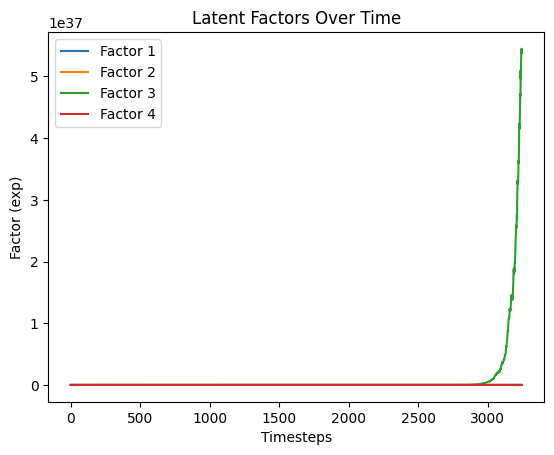

In [ ]:
#all_factors_cumsum = all_factors.cumsum(dim=0)
#all_factors_exp = all_factors_cumsum.exp()



import matplotlib.pyplot as plt
for factor_idx in range(all_factors_exp.shape[1]):  # Loop over factors
    plt.plot(all_factors_exp[:, factor_idx], label=f"Factor {factor_idx + 1}")
plt.title("Latent Factors Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Factor (exp)")
plt.legend()
plt.show()

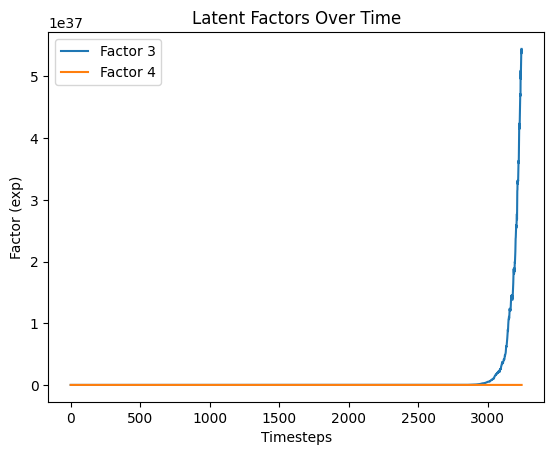

In [ ]:
import matplotlib.pyplot as plt
for factor_idx in range(2,4):  # Loop over factors
    plt.plot(all_factors_exp[:, factor_idx], label=f"Factor {factor_idx + 1}")
plt.title("Latent Factors Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Factor (exp)")
plt.legend()
plt.show()

In [ ]:

# def T_log_prob(z, mu, sigmas, nus): # sigma is standard deviation
#       # z have shape (N,N_t), mu have shape (1,N_t)
#       z = z - mu # (20,N_t) <-> (1,N_t) = (20, N_t)
#       scaled_z = z / sigmas # (20,N_t) </> (1,N_t) = (20,N_t)
#       maha_squareds = scaled_z**2 # (20,N_t)

#       log_prob = ( torch.lgamma((nus + 1) / 2)  # (1,N_t)
#                   - torch.lgamma(nus / 2) # (1,N_t)
#                   - 0.5 * torch.log(nus * torch.pi) # (1,N_t)
#                   - torch.log(sigmas) # (1,N_t)
#                   - (nus + 1) / 2 * torch.log(1 + maha_squareds / nus) # (20, N_t)
#       )
#       return log_prob.sum(dim=1) # sum over stocks, (20,)



# def T_log_prob_x_giv_z(r_future, pred_mean, sigmas, nus):
#     # r_future have shape (1,N_t); pred_mean have shape (N, N_t)
#     res = r_future - pred_mean  # (20, N_t)
#     scaled_res = res / (sigmas + 1e-6)  # Avoid division instability
#     maha_squareds = scaled_res**2  # (20, N_t)

#     log_prob = (
#         torch.lgamma((nus + 1) / 2)
#         - torch.lgamma(nus / 2)
#         - 0.5 * torch.log(nus * torch.pi)
#         - torch.log(sigmas)
#         - (nus + 1) / 2 * torch.log(1 + maha_squareds / nus)
#     )

#     # Tensor log-probability for gradients
#     total_log_prob = log_prob.sum(dim=1)  # (20,)

#     # Scalars for monitoring/debugging
#     maha_term = ((nus + 1) / 2 * torch.log(1 + maha_squareds / nus)).detach().sum().item()
#     sigma_term = (-torch.log(sigmas)).detach().sum().item()

#     return total_log_prob, maha_term, sigma_term
